
**Métodos Computacionales 2**

**Universidad de los Andes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.style.use('dark_background')

## Transformada de Fourier

Es una transformada matemática que descompone una función (a menudo una función del tiempo o una señal) en sus frecuencias constituyentes.

\begin{equation}g(\xi) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} f(x)\ e^{-2\pi i x \xi}\,dx\end{equation}


La transformada de Fourier inversa es

\begin{equation}f(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} g(\xi)\ e^{2 \pi i x \xi}\,d\xi\end{equation}

y permite obtener $f(x)$ a partir de las frecuencias constituyentes $g(\xi)$.

## Transformada de Fourier discreta (DFT)

transforma una secuencia de $N$ números $\{\textbf{x}_n\}=x_0, x_1, ...,x_{N-1}$ (reales o complejos) en otra secuencia de números complejos, $\{\textbf{X}_k\}=X_0, X_1, ...,X_{N-1}$ que se define por

$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}$$

La transformada de fourier inversa es

$$x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k \cdot e^{i~2\pi~k~n~/~N}$$

Implementar directamente estas ecuaciones es fácil pero exige del orden de $\mathcal{O}[N^2]$ operaciones para una secuencia de entrada de longitud $N$ por lo que es poco eficiente comparado con el algoritmo de Cooley-Tukey.

In [2]:
def DFT_lenta(x):
    x = np.array(x) ### linspace en el tiempo
    N = x.shape[0]
    ns = np.arange(N).reshape(-1, 1)
    ks = np.arange(N)
    return np.exp(-2.0j*np.pi*ns*ks / N) @ x

def obtener_frecuencias_y_amplitudes(f, N):
    #t = np.arange(0, 2*np.pi, (2*np.pi)/N)
    t = np.arange(0, 1, 1/N)
    x = f(t)
    X = DFT_lenta(x)
    return np.arange(N), np.abs(X)
    
def f(t):
    # return 7*np.sin((3)*t) + 5*np.sin((10)*t)
    return 7*np.cos((2*np.pi)*(3)*t) + 5*np.cos((2*np.pi)*(10)*t)

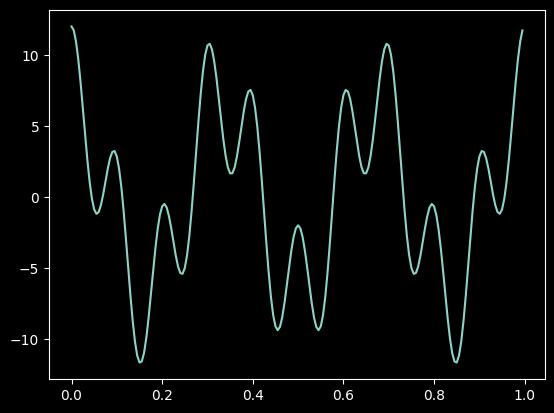

In [3]:
N = 200
t = np.arange(0, 1, 1/N)
plt.plot(t, f(t))

/var/folders/0k/fbxvx_0d4kb5fjxprl22wdtm0000gn/T/ipykernel_59991/2686686476.py:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frecs, amps, use_line_collection = True)


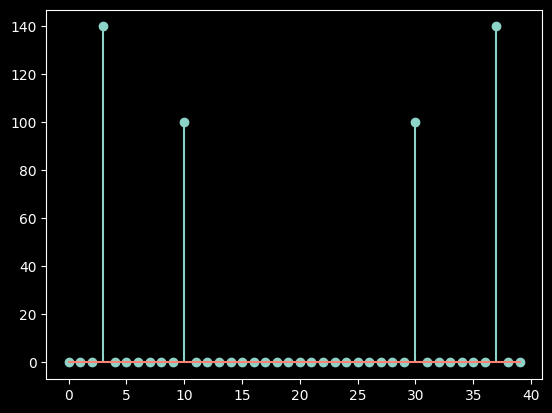

In [4]:
N = 40
frecs, amps = obtener_frecuencias_y_amplitudes(f, N)

plt.stem(frecs, amps, use_line_collection = True)
plt.show()

## Transformada rapida de Fourier

Fue descuvierto por Cooley and Tukey. Se basa en el algoritmo divide y venceras.

\begin{align*}
X_{N + k} &=  \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
\end{align*}

recordar que $\exp[2\pi~i~n] = 1$ para cualquier entero $n$. Lo anterior implica que

$$X_{N+k} = X_k$$

o de forma más general

$$X_{k + i \cdot N} = X_k$$

Cooley y Tukey demostraron que es posible dividir el cálculo DFT en dos partes más pequeñas

\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align}

ejemplo de implementación:

In [5]:
import numpy as np

def FFT_vectorizada(x):
  x = np.asarray(x)
  N = x.shape[0]

  if np.log2(N) % 1 > 0:
    raise ValueError("El tamaño de x debe ser una potencia de 2")

  N_min = min(N, 32)
  n = np.arange(N_min)
  k = n[:, None]
  M = np.exp((-2j * np.pi / N_min) * n * k)
  X = M @ x.reshape((N_min, -1))

  while X.shape[0] < N:
    X_parte1 = X[:, :int(X.shape[1]*0.5)]
    X_parte2 = X[:, int(X.shape[1]*0.5):]
    factor = np.exp(-1j * np.pi * np.arange(X.shape[0])/ X.shape[0])[:, None]
    X = np.vstack([X_parte1 + factor * X_parte2, X_parte1 - factor * X_parte2])

    return X.ravel()

In [6]:
x = np.random.random(1024)

np.allclose(FFT_vectorizada(x), np.fft.fft(x))

%timeit DFT_lenta(x)
%timeit FFT_vectorizada(x)
%timeit np.fft.fft(x)

64 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.5 µs ± 959 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
10.1 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
from IPython.display import Audio

wave1 = np.sin(np.linspace(0, 7000, 100000))
Audio(wave1, rate=44100)

In [8]:
duracion = 6.0
frecuencia = 320
hertz = 44100

def f(t):
  return t*np.sin(t/15)*np.cos(t**2/50) + np.tanh((t/13)**2)*3/2

def crear_onda(f, duracion, frecuencia, hertz):
  samples = np.arange(hertz * duracion) / hertz
  t = 2*np.pi*frecuencia*samples
  return f(t)

wave2 = crear_onda(f, duracion, frecuencia, hertz)

Audio(wave2, rate=hertz)

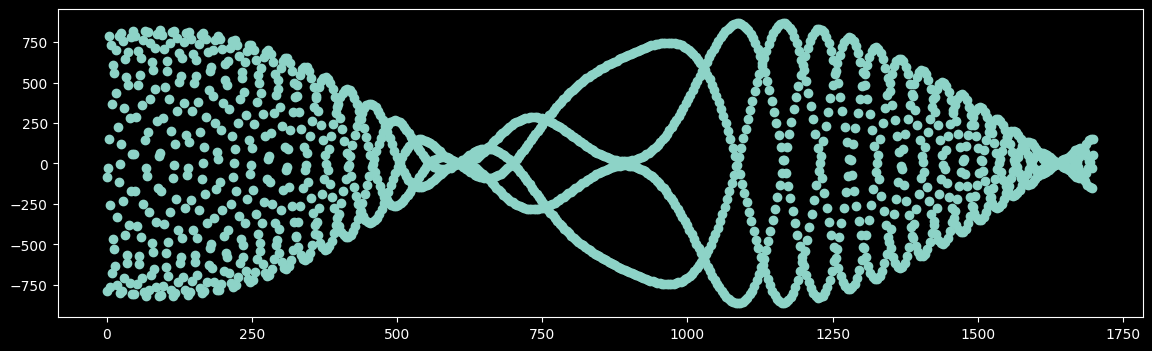

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(wave2[18000:19700],'o')
#plt.plot(wave2[18000:19700])
plt.show()

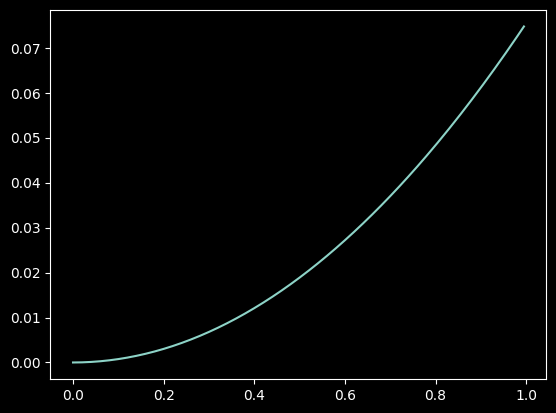

In [10]:
N = 200
t = np.arange(0, 1, 1/N)
y = t*np.sin(t/15)*np.cos(t**2/50) + np.tanh((t/13)**2)*3/2
plt.plot(t, y)

In [11]:
duracion = 6.0
frecuencia = 5
hertz = 40000

def f1(t):
  return 10*np.sin(50*t)

def f2(t):
  return 10*np.sin(271*t)

In [12]:
wave1 = crear_onda(f1, duracion, frecuencia, hertz)
Audio(wave1, rate=hertz)

In [13]:
wave2 = crear_onda(f2, duracion, frecuencia, hertz)
Audio(wave2, rate=hertz)

In [14]:
wave = wave1 + wave2
Audio(wave, rate=hertz)

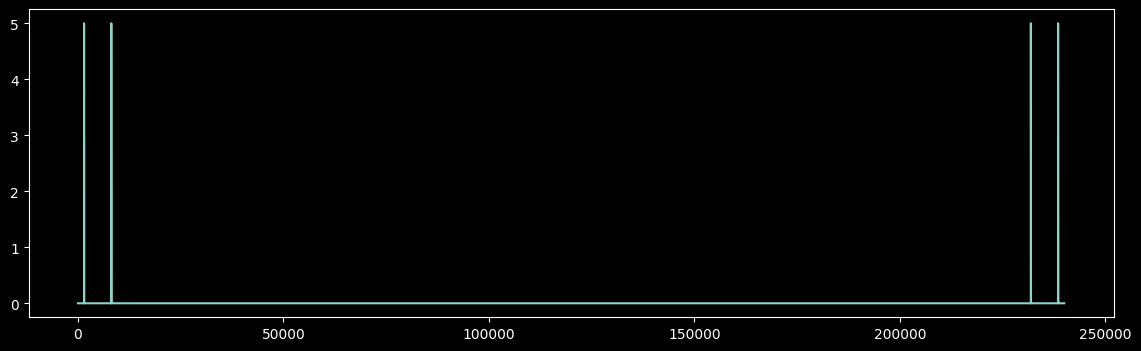

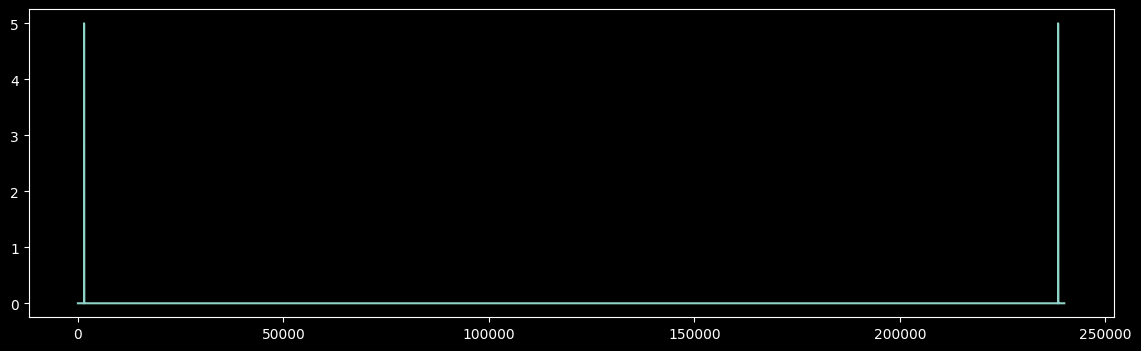

In [15]:
ft_wave = np.fft.fft(wave)

plt.figure(figsize=(14, 4))
y = (np.abs(ft_wave))/len(wave)
plt.plot(y)
plt.show()
#"""

#eliminar frecuencia alta:
a = 10 # margen
pico = 8130 # ubicación del pico
ft_wave[pico-a:pico+a] = 0
ft_wave[-pico-a:-pico+a] = 0

plt.figure(figsize=(14, 4))
y = (np.abs(ft_wave))/len(wave)
plt.plot(y)
plt.show()
#"""

In [16]:
wave_a = np.fft.ifft(ft_wave)
Audio(wave_a.real, rate=hertz)

**Referencias**


**Profesor: Diego Alberto Castro Rodríguez**